## Bitcoin Notebook
#### Run in *pyvizenv* environment in order to visualize dashboard at the end of the notebook.


### Data Preparation

In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
from datetime import datetime, date
from functools import reduce
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# Load the fear and greed sentiment data for Bitcoin (only fear and greed index)
fng_df = pd.read_csv('data/fng.csv')
fng_df = fng_df.rename(columns={'date':'Date', 'value_classification':'fng_class'})
fng_df = fng_df.drop(columns=['value'])
mapping = {'Extreme Fear':'-1.0', 'Fear':'-0.5', 'Neutral':'0.0', 
        'Greed':'0.5', 'Extreme Greed':'1.0'}
fng_df['fng_class'] = fng_df['fng_class'].map(mapping)
fng_df['fng_class'] = pd.to_numeric(fng_df['fng_class'])
fng_df['fng_class'] = fng_df['fng_class'].astype(float)
fng_df.set_index(['Date'], inplace=True)

In [3]:
# Load the vader sentiment data for Bitcoin
btc_vader_df = pd.read_csv('data/btc_vader.csv', infer_datetime_format=True, parse_dates=True)
btc_vader_df["Publish Date"] = [date[0:10] for date in btc_vader_df["Publish Date"]]
btc_vader_df = btc_vader_df.drop(columns=["Post ID", "Title", "Url", "Author", "Score", "Total No. of Comments", "Permalink",
        "title_pos", "title_neu", "title_neg", "title_sent"], axis=1)
btc_vader_df.rename(columns = {'Publish Date':'Date', 'title_compound': 'vader_compound'}, inplace = True)
btc_vader_df['vader_compound'] = btc_vader_df['vader_compound'].astype(float).round(decimals=2)
btc_vader_df.set_index(['Date'], inplace=True)

In [4]:
# Load the historical closing prices for Bitcoin
btc_close_df = pd.read_csv('data/btc_prices.csv')
btc_close_df = btc_close_df.sort_index()
btc_close_df = btc_close_df.rename(columns={'date':'Date', 'close':'close_price'})
btc_close_df = btc_close_df.drop(["symbol", "volume"], axis=1)
btc_close_df.set_index(['Date'], inplace=True)

In [5]:
# Load the exponential weighted moving average data for Bitcoin
btc_ewm_df = pd.read_csv('data/btc_ema.csv')
btc_ewm_df = btc_ewm_df.sort_index()
btc_ewm_df = btc_ewm_df.rename(columns={'date':'Date', 'crossover_signal':'ewm_cross_signal'})
btc_ewm_df = btc_ewm_df.drop(["symbol", "close", "volume", "daily_return", "fast_close", "slow_close", "crossover_long", "crossover_short"], axis=1)
btc_ewm_df['ewm_cross_signal'] = btc_ewm_df['ewm_cross_signal'].astype(float)
btc_ewm_df.set_index(['Date'], inplace=True)

In [6]:
# Load the money flow index for Bitcoin
btc_mfi_df = pd.read_csv('data/btc_mfi.csv')
btc_mfi_df = btc_mfi_df.sort_index()
btc_mfi_df = btc_mfi_df.rename(columns={'date':'Date'})
btc_mfi_df = btc_mfi_df.drop(["symbol", "close", "volume", "Buy", "Sell"], axis=1)
btc_mfi_df['MFI'] = btc_mfi_df['MFI'].round(decimals=2)
btc_mfi_df["mfi_std"] = (btc_mfi_df['MFI'] - btc_mfi_df['MFI'].min())/(btc_mfi_df['MFI'].max() - btc_mfi_df['MFI'].min())
btc_mfi_df = btc_mfi_df.drop(columns=['MFI'])
btc_mfi_df.set_index(['Date'], inplace=True)

In [7]:
# Load the money flow index for Bitcoin
btc_google_df = pd.read_csv('data/btc_google.csv')
btc_google_df = btc_google_df.sort_index()
btc_google_df = btc_google_df.rename(columns={'Google Search Count':'google_search'})
btc_google_df['google_search'] = btc_google_df['google_search'].astype(float)
btc_google_df["google_std"] = (btc_google_df['google_search'] - btc_google_df['google_search'].min())/(btc_google_df['google_search'].max() - btc_google_df['google_search'].min())
btc_google_df = btc_google_df.drop(columns=['google_search'])
btc_google_df.set_index(['Date'], inplace=True)

In [8]:
# MERGE the closing price, ewm, fng, mfi, and Google DataFrames into a single DataFrame
btc_dfs = [btc_close_df, btc_ewm_df, fng_df, btc_mfi_df, btc_google_df]
btc_data_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), btc_dfs)
btc_df = btc_data_df.merge(btc_vader_df, on = 'Date', how = 'left')
btc_df.rename(columns = {'mfi_std':'mfi', 'google_std':'google_search'}, inplace = True)
btc_df['vader_compound'] = btc_df['vader_compound'].fillna(0)
btc_df = btc_df.reset_index().drop_duplicates(subset="Date", keep="first")
btc_df = btc_df.set_index("Date").sort_index()
round(btc_df,2).head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound
Date,,,,,,
2019-02-11,3591.7,1.0,-0.5,0.52,0.02,0.3
2019-02-12,3588.9,1.0,-0.5,0.59,0.02,0.0
2019-02-13,3579.8,1.0,0.0,0.49,0.02,0.0
2019-02-14,3562.4,1.0,0.0,0.52,0.02,0.0
2019-02-15,3567.4,1.0,-0.5,0.49,0.02,0.0


In [9]:
# Load the gas price data for Bitcoin
btc_gas_df = pd.read_csv('data/btc_fees.csv')
btc_gas_df = btc_gas_df.sort_index()
btc_gas_df["bitcoin_Date"] = [date[0:10] for date in btc_gas_df["bitcoin_Date"]]
btc_gas_df = btc_gas_df.rename(columns={'bitcoin_Date':'Date'})
btc_gas_df["gas_std"] = (btc_gas_df['bitcoin_Fee'] - btc_gas_df['bitcoin_Fee'].min())/(btc_gas_df['bitcoin_Fee'].max() - btc_gas_df['bitcoin_Fee'].min())
btc_gas_df.set_index(['Date'], inplace=True)
btc_gas_df = btc_gas_df.drop(columns=['bitcoin_Fee'], axis=1)

In [10]:
# Load the mining difficulty data for Bitcoin
btc_diff_df = pd.read_csv('data/btc_difficulty.csv')
btc_diff_df = btc_diff_df.sort_index()
btc_diff_df["Date"] = [date[0:10] for date in btc_diff_df["Date"]]
btc_diff_df = btc_diff_df.reset_index().drop_duplicates(subset='Date', keep='last') #.set_index('Date').sort_index()
btc_diff_df = btc_diff_df.drop(columns = ["index"]).set_index('Date').sort_index()
btc_diff_df["diff_std"] = (btc_diff_df['Difficulty'] - btc_diff_df['Difficulty'].min())/(btc_diff_df['Difficulty'].max() - btc_diff_df['Difficulty'].min())
btc_diff_df = btc_diff_df.drop(columns=['Difficulty'], axis=1)

In [11]:
# Load the actual Bitcoin value (transfers) data for Bitcoin (volume of transactions by day)
btc_value_df = pd.read_csv('data/btc_size.csv') #, index_col="date", infer_datetime_format=True, parse_dates=True)
btc_value_df = btc_value_df.sort_index()
btc_value_df["bitcoin_Date"] = [date[0:10] for date in btc_value_df["bitcoin_Date"]]
btc_value_df = btc_value_df.rename(columns={'bitcoin_Date':'Date'})
btc_value_df['bitcoin_Size'] = btc_value_df['bitcoin_Size'].astype(float)
btc_value_df["transfers_std"] = (btc_value_df['bitcoin_Size'] - btc_value_df['bitcoin_Size'].min())/(btc_value_df['bitcoin_Size'].max() - btc_value_df['bitcoin_Size'].min())
btc_value_df.set_index(['Date'], inplace=True)
btc_value_df = btc_value_df.drop(columns=['bitcoin_Size'], axis=1)

In [12]:
# MERGE the mining data into a single DataFrame
dfs = [btc_diff_df, btc_gas_df, btc_value_df]
btc_mining_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs)
btc_string_time = "2019-02-08"
btc_datetime = datetime.strptime(btc_string_time, "%Y-%m-%d")
btc_mining_df.rename(columns = {'f0_':'Date', 'diff_std':'mining_difficulty', 'gas_std': 'gas_price', 'transfers_std':'total_transfers' }, inplace = True)
round(btc_mining_df,2).head()

,mining_difficulty,gas_price,total_transfers
Date,,,
2019-01-02,1.0,0.05,0.55
2019-01-03,1.0,0.06,0.58
2019-01-04,1.0,0.06,0.55
2019-01-05,1.0,0.03,0.51
2019-01-06,1.0,0.05,0.44


In [13]:
# MERGE btc_mining_df with btc_df
btc_master_df = btc_df.merge(btc_mining_df, on = 'Date', how = 'left')
round(btc_master_df,2).head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers
Date,,,,,,,,,
2019-02-11,3591.7,1.0,-0.5,0.52,0.02,0.3,0.9,0.07,0.61
2019-02-12,3588.9,1.0,-0.5,0.59,0.02,0.0,0.9,0.11,0.65
2019-02-13,3579.8,1.0,0.0,0.49,0.02,0.0,0.9,0.11,0.68
2019-02-14,3562.4,1.0,0.0,0.52,0.02,0.0,0.9,0.08,0.60
2019-02-15,3567.4,1.0,-0.5,0.49,0.02,0.0,0.9,0.08,0.54


---

## Random Forest Regressor for Multiple Features

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.datasets import load_boston
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Bad key savefig.frameon in file /Users/cathyslider/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/cathyslider/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/cathyslider/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  #

### Fitting and Predicting

In [15]:
# Define features set and target vector
dataset = btc_master_df
X = btc_master_df[['mining_difficulty', 'ewm_cross_signal','fng_class','mfi','google_search', 'vader_compound', 'gas_price', 'total_transfers']]
y = btc_master_df['close_price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
# Create Random Forest Regressor and fit the model
rf_model = RandomForestRegressor(n_estimators=10, random_state=78)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=78)

In [18]:
# Make predictions using the testing data
predictions = rf_model.predict(X_test)

### Feature Importance

In [19]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.7287813503654398, 'google_search'),
 (0.21117430799845022, 'mining_difficulty'),
 (0.0313672401881296, 'fng_class'),
 (0.01126562558080057, 'mfi'),
 (0.008596463941468404, 'gas_price'),
 (0.004602856938098654, 'total_transfers'),
 (0.0021164354756039185, 'ewm_cross_signal'),
 (0.002095719512008804, 'vader_compound')]

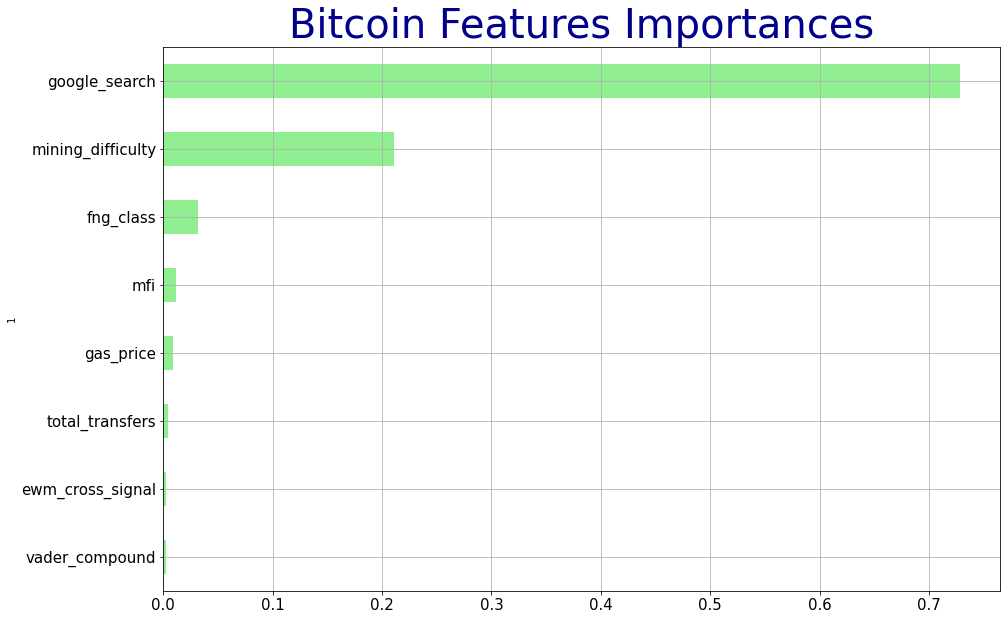

In [20]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', figsize=(15,10), grid=True, 
                        fontsize=15, legend=False)
plt.title('Bitcoin Features Importances', fontsize=40, color='darkBlue')
plt.savefig('images/btc-features-import.png')

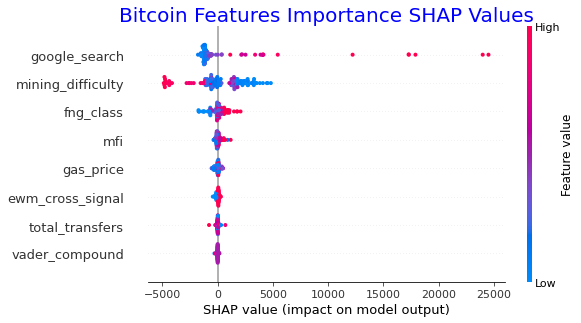

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot SHAP Values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

plt.title('Bitcoin Features Importance SHAP Values', fontsize=20, color='blue', pad=(5.0))
shap.summary_plot(shap_values, X_test)
plt.savefig('images/btc-features-import-shap.png')

### Model Evaluation

In [22]:
# r2_score (fit score) test
r2_score(y_test, rf_model.predict(X_test))

0.9805327370039023

In [23]:
# FIX PERCENTAGE mean squared error
mse = mean_squared_error(y_test, rf_model.predict(X_test), squared=False)
mse

771.372492195238

In [24]:
rmse = np.sqrt(mse)
rmse

27.773593433245868

In [25]:
btc_master_train_df, btc_master_test_df= np.split(btc_master_df, [int(.8 *len(btc_master_df))])
pred_df = pd.DataFrame(predictions, columns=['prediction_price'])
pred_df.index = btc_master_test_df.index
round(pred_df,2).head()

,prediction_price
Date,
2020-08-28,3944.24
2020-08-29,6782.81
2020-08-30,13065.91
2020-08-31,17903.66
2020-09-01,9850.19


In [26]:
#JOIN dataframes
btc_combined = btc_master_df.join(pred_df)
round(btc_combined,2).head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price
Date,,,,,,,,,,
2019-02-11,3591.7,1.0,-0.5,0.52,0.02,0.3,0.9,0.07,0.61,NaN
2019-02-12,3588.9,1.0,-0.5,0.59,0.02,0.0,0.9,0.11,0.65,NaN
2019-02-13,3579.8,1.0,0.0,0.49,0.02,0.0,0.9,0.11,0.68,NaN
2019-02-14,3562.4,1.0,0.0,0.52,0.02,0.0,0.9,0.08,0.60,NaN
2019-02-15,3567.4,1.0,-0.5,0.49,0.02,0.0,0.9,0.08,0.54,NaN


In [27]:
#Calculate percent change
btc_master_pct_change = btc_combined.pct_change()
btc_master_pct_change_corr = btc_master_pct_change.corr()
round(btc_master_pct_change_corr,2)

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price
close_price,1.00,0.03,-0.04,0.37,-0.00,0.17,0.03,0.10,0.01,-0.05
ewm_cross_signal,0.03,1.00,-0.02,-0.00,-0.02,0.05,0.03,-0.09,-0.04,0.11
fng_class,-0.04,-0.02,1.00,-0.07,-0.02,-0.02,0.01,-0.04,-0.07,0.02
mfi,0.37,-0.00,-0.07,1.00,-0.01,0.19,0.00,0.03,-0.01,0.17
google_search,-0.00,-0.02,-0.02,-0.01,1.00,-0.00,0.01,0.12,0.10,0.13
vader_compound,0.17,0.05,-0.02,0.19,-0.00,1.00,0.00,0.04,-0.02,0.10
mining_difficulty,0.03,0.03,0.01,0.00,0.01,0.00,1.00,0.02,0.14,-0.03
gas_price,0.10,-0.09,-0.04,0.03,0.12,0.04,0.02,1.00,0.47,0.04
total_transfers,0.01,-0.04,-0.07,-0.01,0.10,-0.02,0.14,0.47,1.00,0.03
prediction_price,-0.05,0.11,0.02,0.17,0.13,0.10,-0.03,0.04,0.03,1.00


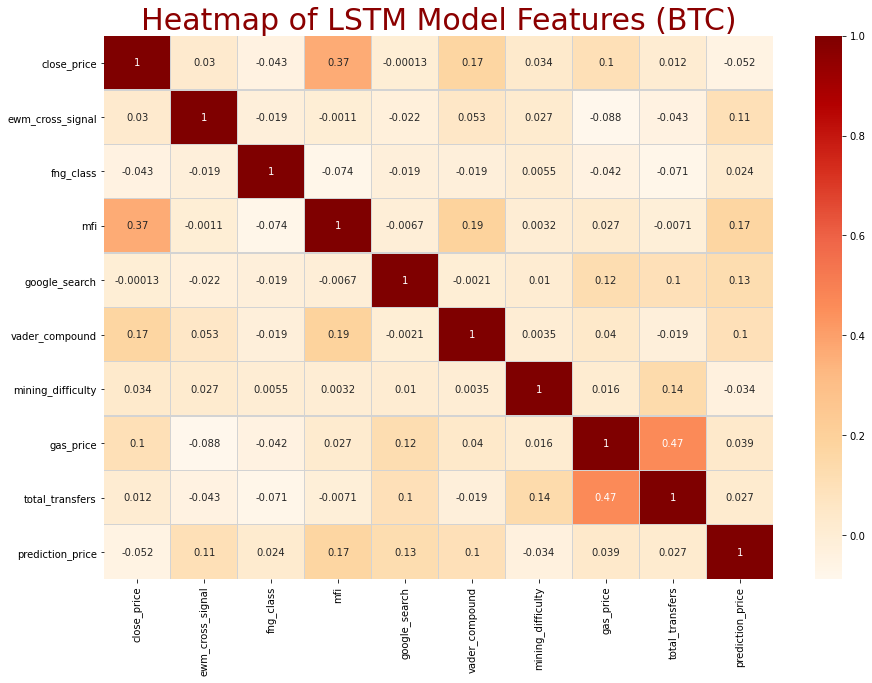

In [28]:
# Plot features importances heatmap
plt.figure(figsize = (15,10))
sns.heatmap(btc_master_pct_change_corr,cmap='OrRd', annot=True, linecolor='lightgray', linewidths=.3)
plt.title('Heatmap of LSTM Model Features (BTC)', color='darkred', pad=3.0, fontsize = 30)
plt.savefig("images/btc-rf-heatmap.png")

---

### RF Analysis for Win/Lose Call Accuracy

In [29]:
#Add column for "actual_day_positive_move" positive move = true & negative move = false
btc_combined["actual_day_positive_move"] = btc_combined["close_price"]-btc_combined["close_price"].shift(1)>0
btc_combined.tail()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move
Date,,,,,,,,,,,
2021-01-12,34046.4,1.0,1.0,0.534022,1.0,0.00,0.0,0.565998,0.761437,12003.31,False
2021-01-13,37390.1,1.0,1.0,0.553777,1.0,0.42,0.0,0.467109,0.746573,15140.19,True
2021-01-14,39151.6,1.0,1.0,0.569141,1.0,0.00,0.0,0.483975,0.739883,10593.16,True
2021-01-15,36739.8,1.0,1.0,0.506779,1.0,0.00,0.0,0.504073,0.792897,9185.84,False
2021-01-16,37064.9,1.0,1.0,0.533118,1.0,0.00,0.0,0.299330,0.753545,7096.96,True


In [30]:
#Add column for "predicted day positive move" positive move = true & negative move = false
btc_combined["predicted_day_positive_move"] = btc_combined["prediction_price"]-btc_combined["prediction_price"].shift(1)>0
btc_combined.tail()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move,predicted_day_positive_move
Date,,,,,,,,,,,,
2021-01-12,34046.4,1.0,1.0,0.534022,1.0,0.00,0.0,0.565998,0.761437,12003.31,False,True
2021-01-13,37390.1,1.0,1.0,0.553777,1.0,0.42,0.0,0.467109,0.746573,15140.19,True,True
2021-01-14,39151.6,1.0,1.0,0.569141,1.0,0.00,0.0,0.483975,0.739883,10593.16,True,False
2021-01-15,36739.8,1.0,1.0,0.506779,1.0,0.00,0.0,0.504073,0.792897,9185.84,False,False
2021-01-16,37064.9,1.0,1.0,0.533118,1.0,0.00,0.0,0.299330,0.753545,7096.96,True,False


In [31]:
# Add "correct call" column if both had true or both had false we have a true 
btc_combined["Correct Call Count"] = np.where(btc_combined["actual_day_positive_move"]==btc_combined["predicted_day_positive_move"], True, False)
btc_combined.to_csv(r"data/btc_combined.csv", index = False)

In [32]:
#Remove rows w/o predicted prices
rf_btc_calls = btc_combined.iloc[565:]
rf_btc_calls.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move,predicted_day_positive_move,Correct Call Count
Date,,,,,,,,,,,,,
2020-08-29,11480.9,1.0,1.0,0.436540,0.065934,0.00,0.065103,0.220339,0.753251,6782.81,False,True,False
2020-08-30,11713.1,1.0,0.5,0.413944,0.065934,0.64,0.065103,0.214243,0.643522,13065.91,True,True,True
2020-08-31,11656.9,1.0,0.5,0.370820,0.043956,0.20,0.065103,0.309957,0.680470,17903.66,False,True,False
2020-09-01,11926.8,1.0,0.5,0.499548,0.043956,0.00,0.065103,0.429974,0.762269,9850.19,True,False,False
2020-09-02,11396.9,1.0,1.0,0.532602,0.043956,0.32,0.065103,0.435518,0.722656,10327.63,False,True,False


In [33]:
# convert to pivot table
rf_btc_calls = rf_btc_calls.pivot_table(index=['Correct Call Count'], aggfunc='size')
rf_btc_calls

Correct Call Count
False    68
True     73
dtype: int64

In [34]:
# calculate lose rate
rf_btc_calls['lose_rate'] = (rf_btc_calls.iloc[0] / (141))*100
round(rf_btc_calls,2)

Correct Call Count
False        68.00
True         73.00
lose_rate    48.23
dtype: float64

In [35]:
# calculate win rate
rf_btc_calls['win_rate'] = (rf_btc_calls.iloc[1] / (141))*100
round(rf_btc_calls,2)

Correct Call Count
False        68.00
True         73.00
lose_rate    48.23
win_rate     51.77
dtype: float64

---

## Features Decision Tree

In [36]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from IPython.display import Image

In [37]:
# Prepare the data
dataset = btc_combined
X = btc_combined[['close_price','ewm_cross_signal','fng_class','mfi','google_search', 'vader_compound', 'mining_difficulty', 'gas_price', 'total_transfers']]
y = btc_combined["close_price"]

In [38]:
# Fit the regressor, set max_depth = 3
regr = DecisionTreeRegressor(max_depth=3, min_samples_leaf=25, random_state=78)
model = regr.fit(X, y)

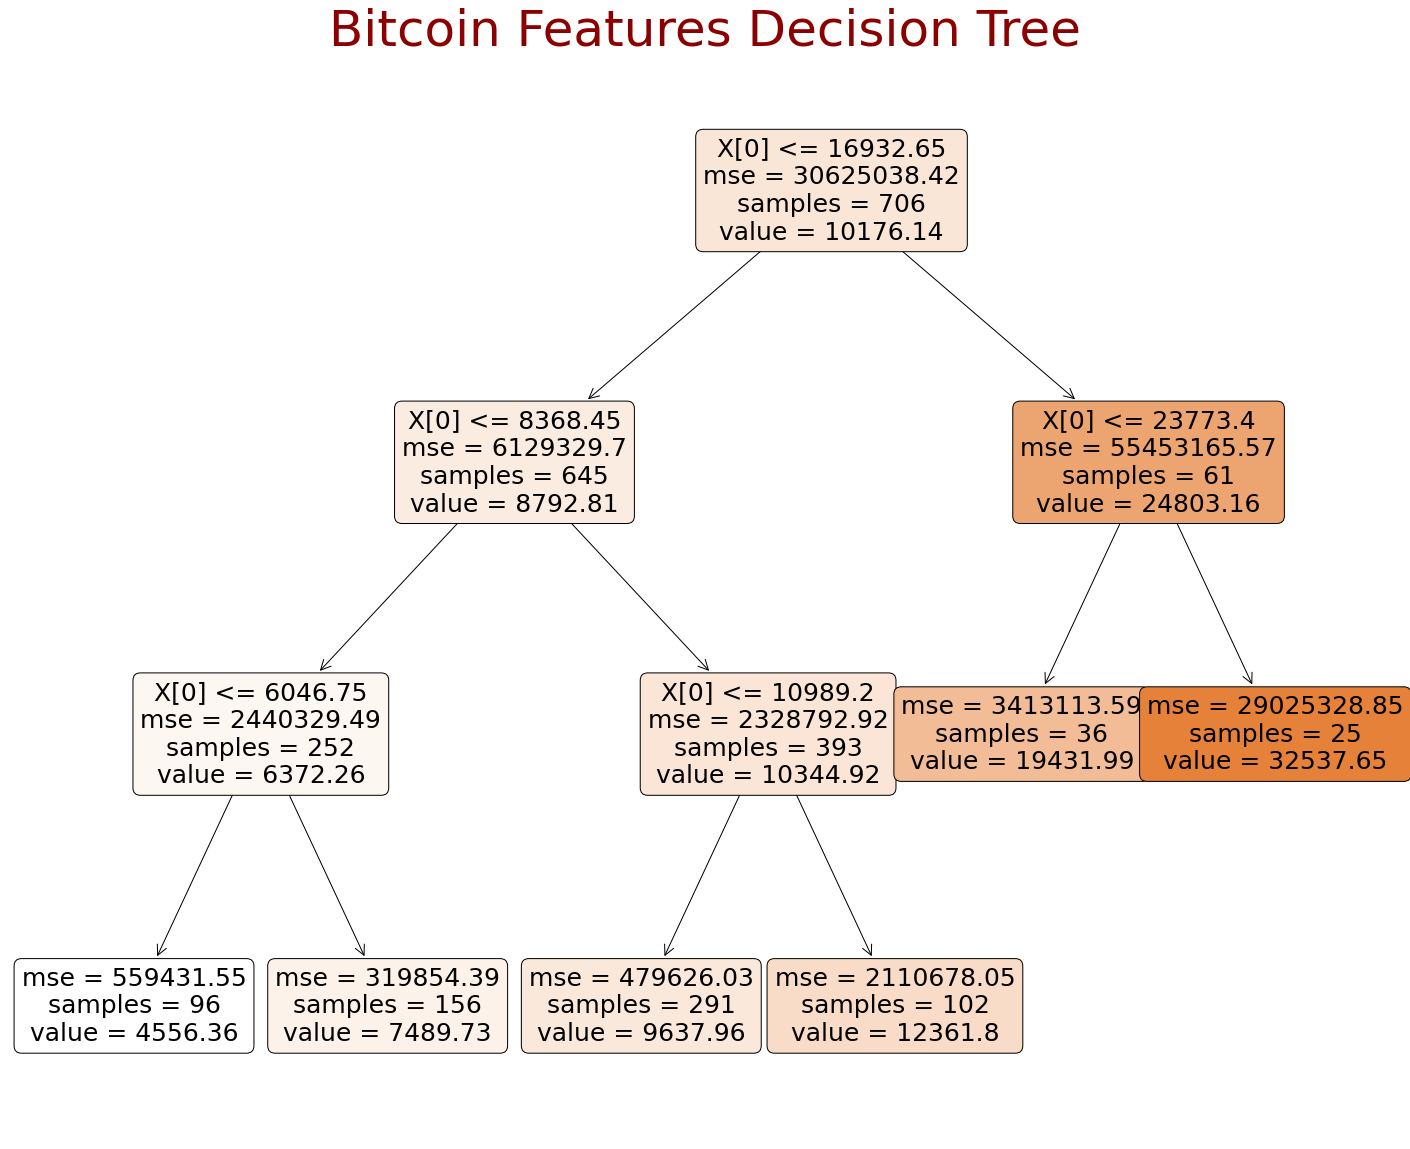

In [39]:
fig = plt.figure(figsize=(25,20))

fig = tree.plot_tree(regr, filled=True, rounded=True, precision=2, fontsize=25)
plt.title('Bitcoin Features Decision Tree', fontsize=50, color='darkred')
plt.savefig('images/btc-decision-tree.png')

In [40]:
btc_combined = btc_master_df.join(pred_df)
np.round(btc_combined,2)
btc_combined.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price
Date,,,,,,,,,,
2019-02-11,3591.7,1.0,-0.5,0.519432,0.021978,0.3,0.899538,0.071305,0.610672,NaN
2019-02-12,3588.9,1.0,-0.5,0.589283,0.021978,0.0,0.899538,0.110306,0.645904,NaN
2019-02-13,3579.8,1.0,0.0,0.489606,0.021978,0.0,0.899538,0.114917,0.683483,NaN
2019-02-14,3562.4,1.0,0.0,0.519045,0.021978,0.0,0.899538,0.081920,0.604591,NaN
2019-02-15,3567.4,1.0,-0.5,0.487799,0.021978,0.0,0.899538,0.082915,0.537446,NaN


----

## LSTM Recurrent Neural Network for Historical and Predicted Closing Prices

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy.random import seed
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler

In [42]:
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)

In [43]:
# Create function for features (X) and targeet(y)
def window_data(btc_combined, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(btc_combined) - window - 1):
        features = btc_combined.iloc[i:(i + window), feature_col_number]
        target = btc_combined.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [44]:
# Predict Closing Prices 
window_size = 10

# Column 0 is `Close Price`
feature_column = 0
target_column = 0
X, y = window_data(btc_combined, window_size, feature_column, target_column)

In [45]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test_scaler = y[split:]

In [46]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test_scaler = scaler.transform(y_test_scaler)


In [47]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

### Build and Train the Model

In [48]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,             #carries the values forward
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))


In [49]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [50]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [51]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=100, verbose=0)

---

### Model Performance

In [52]:
# Evaluate the model
model.evaluate(X_test, y_test_scaler)

7/7 [==============================] - 1s 3ms/step - loss: 0.0077


0.007664936129003763

In [53]:
# Make some predictions
predicted = model.predict(X_test)

In [54]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
#np.round(predicted_prices, 2)
real_prices = scaler.inverse_transform(y_test_scaler.reshape(-1, 1))

In [55]:
# Create a DataFrame of Real and Predicted values
lstm_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = btc_combined.index[-len(real_prices): ]) 
np.around(lstm_df, 2)
round(lstm_df,2).head()

,Real,Predicted
Date,,
2020-06-22,9284.7,9286.740234
2020-06-23,9694.0,9303.419922
2020-06-24,9622.3,9295.339844
2020-06-25,9282.0,9290.549805
2020-06-26,9233.5,9307.139648


FixedFormatter should only be used together with FixedLocator


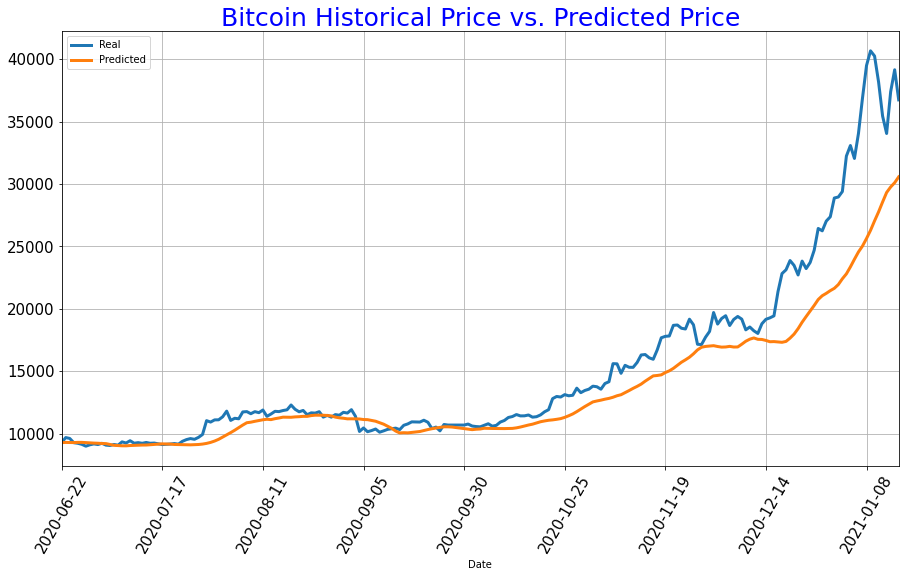

In [56]:
# Plot price comparison
lstm_df.plot(figsize=(15,8), fontsize=15, grid=True, linewidth=3, rot=60)
plt.title('Bitcoin Historical Price vs. Predicted Price', fontsize=25, 
          fontweight=15, color='blue', pad=1.0)
plt.savefig('images/btc-lstm.png')

In [57]:
#Add column for "actual_day_positive_move" positive move = true & negative move = false
lstm_df["actual_day_positive_move"] = lstm_df["Real"]-lstm_df["Real"].shift(1)>0
lstm_df.tail()

,Real,Predicted,actual_day_positive_move
Date,,,
2021-01-12,35439.3,28561.027344,False
2021-01-13,34046.4,29322.234375,False
2021-01-14,37390.1,29763.156250,True
2021-01-15,39151.6,30105.730469,True
2021-01-16,36739.8,30573.498047,False


In [58]:
#Add column for "predicted day positive move" positive move = true & negative move = false
lstm_df["predicted_day_positive_move"] = lstm_df["Predicted"]-lstm_df["Predicted"].shift(1)>0
lstm_df.tail()

,Real,Predicted,actual_day_positive_move,predicted_day_positive_move
Date,,,,
2021-01-12,35439.3,28561.027344,False,True
2021-01-13,34046.4,29322.234375,False,True
2021-01-14,37390.1,29763.156250,True,True
2021-01-15,39151.6,30105.730469,True,True
2021-01-16,36739.8,30573.498047,False,True


In [59]:
#Add "correct call" column if both had true or both had false we have a true 
lstm_df["Call Accuracy Count"] = np.where(lstm_df["actual_day_positive_move"]==lstm_df["predicted_day_positive_move"], True, False)
lstm_df.tail()

,Real,Predicted,actual_day_positive_move,predicted_day_positive_move,Call Accuracy Count
Date,,,,,
2021-01-12,35439.3,28561.027344,False,True,False
2021-01-13,34046.4,29322.234375,False,True,False
2021-01-14,37390.1,29763.156250,True,True,True
2021-01-15,39151.6,30105.730469,True,True,True
2021-01-16,36739.8,30573.498047,False,True,False


In [60]:
#Create pivot table
lstm_df = lstm_df.pivot_table(index=['Call Accuracy Count'], aggfunc='size')
lstm_df_pivot = lstm_df
lstm_df_pivot

Call Accuracy Count
False     94
True     115
dtype: int64

In [61]:
# Calculate lose rate
lstm_df_pivot['lose_rate'] = (lstm_df_pivot.iloc[0] / (209))*100
round(lstm_df_pivot,2)

Call Accuracy Count
False         94.00
True         115.00
lose_rate     44.98
dtype: float64

In [62]:
# Calculate win rate
lstm_df_pivot['win_rate'] = (lstm_df_pivot.iloc[1] / (209))*100
round(lstm_df_pivot,2)

Call Accuracy Count
False         94.00
True         115.00
lose_rate     44.98
win_rate      55.02
dtype: float64

---

## Which Model Had the Best Call Accuracy Rate?

In [63]:
#Create combined pivot table
combined_pivot = pd.concat([rf_btc_calls, lstm_df_pivot], axis=1, keys=['Random Forest Calls', 'LSTM RNN Calls'], join='inner')
round(combined_pivot,2)

,Random Forest Calls,LSTM RNN Calls
False,68.00,94.00
True,73.00,115.00
lose_rate,48.23,44.98
win_rate,51.77,55.02


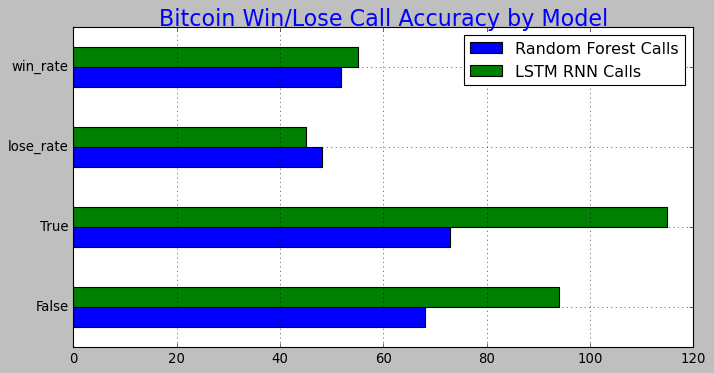

In [64]:
# Plot call accuracy by model
plt.style.use('classic')
combined_pivot = combined_pivot.plot(kind='barh', figsize=(10,5), fontsize=12, grid=True)
plt.title('Bitcoin Win/Lose Call Accuracy by Model', fontsize=20, fontweight=15, color='blue', pad=1.0)
plt.savefig('images/btc-win-lose-compare.png')

---

## Dashboarding

In [65]:
from panel.interact import interact
import plotly.express as px
import panel as pn
pn.extension()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.image as img 
import holoviews as hv
from bokeh.plotting import figure

In [66]:
#Create dashboard panels and tabs
title1 = pn.pane.Markdown('#Indicators or Historical Price - which is the better predictor? ', style={'font-family': "serif", "font-color":"navy"})
title2 = pn.pane.Markdown('#Bitcoin Historical Results', style={'font-family': "serif", "font-color":"navy"})
title3 = pn.pane.Markdown('#Bitcoin Correlation and Features Importance', style={'font-family': "serif", "font-color":"navy"})
title4 = pn.pane.Markdown('#Bitcoin Win/Lose Call Accuracy', style={'font-family': "serif", "font-color":"navy"})

banner = pn.pane.PNG('images/btc-banner.png', width=700, height=100)
lstm = pn.pane.PNG('images/btc-lstm.png', width=700, height=400)
heatmap = pn.pane.PNG('images/btc-rf-heatmap.png', width=800, height=600)
features = pn.pane.PNG('images/btc-features-import.png', width=700, height=400)
win_lose = pn.pane.PNG('images/btc-win-lose-compare.png', width=600)

overview_column = pn.Column(title1,
    '**PROJECT BACKGROUND** - '
    'Can cryptocurrency on-chain data paired with technical indicators '
    'fit to a Machine Learning model be a reliable predictor of '
    'the next daily close?'
    '',       
    'Is historical pricing the best indicator of a next day cryptocurrency price? '
    '',
    'The goal of this project is to determine if either of two models can be used '
    'to accurately predict a next-day price of three cryptocurrencies - ETH, BTC, DASH. '
    'A **Random Forest Regressor** model for technical indicators as features analysis '
    'and an **LSTM Recurrent Neural Network** model for the historical price analysis. ',
    
    '###**Bitcoin Sentiment and Historical Features**',
    btc_df.head(), 
    banner,
    '###**Bitcoin On-Chain Features**',
    btc_mining_df.head(),
    background='#E0DFE5', width=700, height=850, scroll=False)

lstm_column = pn.Column(title2,
    '**How did predicted Bitcoin prices perform against two-year historical prices?**', 
    lstm, background='#E0DFE5', width=800, height=600, scroll=False)

random_forest_column = pn.Column(title3, 
    '**Which features ranked as most important and how did they correlate to the '
    'closing price, predicted price, and other features?**',
    features,
    heatmap,
    background='#E0DFE5', width=800, height=800, scroll=True)

results_column = pn.Column(title4,
    '**Which model had the best call accuracy?**', win_lose,
    background='#E0DFE5', width=700, height=500, scroll=False)               
                       
btc_dashboard = pn.Tabs(
    ("Overview", overview_column),
    ("LSTM RNN", lstm_column),
    ("Random Forest Regressor", random_forest_column),
    ("Results", results_column),
    dynamic=True) #, tabs_location="above", background="#E5E4EB"

### Serve the dashboard by executing the next cell.
To serve the dashboard to a browser, execute the next cell, open terminal, navigate to the directory of this file, and type the following: **panel serve --show filename.ipynb**

Tabs(dynamic=True)
    [0] Column(background='#E0DFE5', height=850, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Markdown(str)
        [5] DataFrame(DataFrame)
        [6] PNG(str, height=100, sizing_mode='fixed', width=700)
        [7] Markdown(str)
        [8] DataFrame(DataFrame)
    [1] Column(background='#E0DFE5', height=600, sizing_mode='fixed', width=800)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] PNG(str, height=400, sizing_mode='fixed', width=700)
    [2] Column(background='#E0DFE5', height=800, scroll=True, sizing_mode='fixed', width=800)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] PNG(str, height=400, sizing_mode='fixed', width=700)
        [3] PNG(str, height=600, sizing_mode='fixed', width=800)
    [3] Column(background='#E0DFE5', height=500, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] PNG(str, width=600)
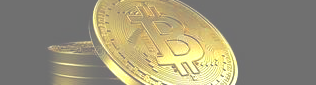

In [67]:
btc_dashboard.servable()